# APSC-5984 Lab 7: API and Database

## 0. Overview

API stands for Application Programming Interface. It is a set of tools meant to interact with other software or database. In this lab, we will use `requests` to interact with two USDA APIs. Later this week, we will also use `sqlite3` to practice building a database on our own.


In [1]:
import pandas as pd
import numpy as np
import requests

## 1. USDA local food portal API

### Configuration

Before you can use the API, you need to get an API key and essentail parameters, such as the database you want to interact with and the query you want to run. Please treat the API key as a password and do not share it with others. Go to the [USDA local food portal](https://www.usdalocalfoodportal.com/fe/fregisterpublicapi) to register for an API key.

In [ ]:
API = "xxxxxxx" # fill in your API key
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
    "Referer": "https://www.google.com/",
}
params = {"apikey": API, "y": 37.221508, "x": -80.423857, "radius": 100}
base_url = "https://www.usdalocalfoodportal.com/api/farmersmarket/"

### Request responses

The responses are usually coded as 3-digit numbers. The most common ones are:

* 1xx - Informational response - the request was received, continuing process
* 2xx - Success - the request was successfully received, understood, and accepted
* 3xx - Redirection - further action needs to be taken in order to complete the request
* 4xx - Client error - the request contains bad syntax or cannot be fulfilled
* 5xx - Server error - the server failed to fulfill an apparently valid request

In most cases, you want to get a 2xx response. If you get a 4xx or 5xx response, you need to check your code and make sure you are using the API correctly.

In [3]:
response = requests.get(base_url, headers=headers, params=params)
response

<Response [200]>

### Parsing JSON

The response from the API is usually in JSON format. JSON stands for JavaScript Object Notation. It is a lightweight data-interchange format. It is not easy for humans to read and write, hense we can call `.json()` and `pd.DataFrame()` to parse the response into a tabular format.

In [4]:
json = response.json()
df = pd.DataFrame(json["data"])
df.head()

,directory_type,directory_name,updatetime,listing_image,listing_id,listing_name,listing_desc,brief_desc,mydesc,contact_name,...,media_blog,location_address,location_state,location_city,location_street,location_zipcode,location_x,location_y,distance,term
0,farmersmarket,farmers market,"Jan 26th, 2021",default-farmersmarket-4-3.jpg,300156,Salem Farmers Market,None,Open: April to December; January to March; <br...,,Market Manager,...,None,"3 East Main Street, Salem, Virginia 24153",Virginia,Salem,3 East Main Street,24153,-80.058606,37.292997,20.684638895041772,
1,farmersmarket,farmers market,"Feb 1st, 2021",default-farmersmarket-4-3.jpg,300469,Grandin Village Farmers Market,None,Open: April to November; November to March; <b...,,Sam Lev,...,None,"2080 Westover Ave SW, Roanoke, Virginia 24015",Virginia,Roanoke,2080 Westover Ave SW,24015,-79.978064,37.265053,24.703908391067827,
2,farmersmarket,farmers market,"Sep 27th, 2021",default-farmersmarket-4-3.jpg,301601,The Historic City Market,None,Open: Year-round<br>Available Products: Fresh ...,,Eric L Pendleton,...,None,"213 Market St SE 3rd Floor, Downtown Roanoke I...",Virginia,Roanoke,"213 Market St SE 3rd Floor, Downtown Roanoke Inc.",24011,-79.939064,37.271606,26.88770808513208,
3,farmersmarket,farmers market,"Aug 23rd, 2021",default-farmersmarket-4-3.jpg,301590,Rocky Mount Farmers Market,None,Open: April to December; <br>Available Product...,,Paul Cauley,...,None,"435 Franklin St, Rocky Mount, Virginia 24151",Virginia,Rocky Mount,435 Franklin St,24151,-79.888073,36.994866,33.41846778835633,
4,farmersmarket,farmers market,"Jan 7th, 2021",default-farmersmarket-4-3.jpg,300467,Wytheville Farmers Market,None,Open: Year-round<br>Available Products: Fresh ...,,Joanne McNulty,...,None,"210 W. Spring Street, Wytheville , Virginia 24368",Virginia,Wytheville,210 W. Spring Street,24368,-81.083367,36.9486397,40.94927484093051,


### Rearranging the data

The data might contain more information than you need. We can use Pandas techniques we learned before to rearrange the data.

In [7]:
cols = [
    "listing_name",
    "brief_desc",
    "contact_name",
    "contact_phone",
    "media_website",
    "media_facebook",
    "media_twitter",
    "location_city",
    "location_state",
    "location_y",
    "location_x",
]

df.loc[:, cols]

,listing_name,brief_desc,contact_name,contact_phone,media_website,media_facebook,media_twitter,location_city,location_state,location_y,location_x
0,Salem Farmers Market,Open: April to December; January to March; <br...,Market Manager,540-375-4098,market.salemva.gov,https://www.facebook.com/SalemVaMarket,https://twitter.com/SalemVaMarket,Salem,Virginia,37.292997,-80.058606
1,Grandin Village Farmers Market,Open: April to November; November to March; <b...,Sam Lev,540-632-1360,www.leapforlocalfood.org/grandin,facebook.com/grandinvillagecommunitymarket,@leapforlocal,Roanoke,Virginia,37.265053,-79.978064
2,The Historic City Market,Open: Year-round<br>Available Products: Fresh ...,Eric L Pendleton,5403422028,Downtownroanoke.org,The Historic City Market,None,Roanoke,Virginia,37.271606,-79.939064
3,Rocky Mount Farmers Market,Open: April to December; <br>Available Product...,Paul Cauley,540-488-2023,None,None,None,Rocky Mount,Virginia,36.994866,-79.888073
4,Wytheville Farmers Market,Open: Year-round<br>Available Products: Fresh ...,Joanne McNulty,276-620-4095,www.wythevillefarmersmarket.com,Wytheville Farmers Market,None,Wytheville,Virginia,36.9486397,-81.083367
5,Galax Farmers Market,Open: 05/11/2023 to 10/28/2023; <br>Available ...,Jordan Shaw,276.733.4145,https://visitgalax.com/,https://www.facebook.com/search/top?q=galaxfar...,,Galax,VA,36.6632146,-80.925742
6,Forest farmers market,Open: April to October; November to December; ...,Dorothy McIntyre,434-665-5475,www.forestfarmersmarket.com,https://www.facebook.com/pages/Forest-farmers-...,https://twitter.com/FFM221,Forest,Virginia,37.3643700,-79.285443
7,King Farmers' Market,Open: May to September; <br>Available Products...,Deb Fox,336-618-1086,www.kingfarmersmarket.com,www.facebook.com/KingFarmersMarket,https://twitter.com/KingFarmersMkt,King,North Carolina,36.276367,-80.341178
8,Lynchburg Community Market,Open: Year-round<br>Available Products: Fresh ...,Ricky Kowalewski,434.455.3962,http://lynchburgcommunitymarket.com/,https://www.facebook.com/LynchburgCommunityMar...,None,Lynchburg,Virginia,37.411517,-79.140379
9,The Market at Second Stage,Open: May to October; November to April; <br>A...,Mary Hurst,434.941.0997,https://secondstageamherst.org/markets,https://www.facebook.com/The-Market-at-Second-...,None,Amherst,Virginia,37.583162,-79.048809


## 2. Agricultural Resource Management Survey (ARMS) API

### API key

Go to [ARMS API](https://www.ers.usda.gov/developer/data-apis/arms-data-api/#apiForm) to obtain an API key for the USDA ARMS API.

In [14]:
API = "xxxxxxx" # fill in your API key
params = {"api_key": API}

### Use `arms/year` to get the list of available years

This API has a lot of data. Based on the documentation https://www.ers.usda.gov/developer/data-apis/arms-data-api/#apiForm, we can use `arms/year` to get the list of available years.

In [8]:
# arms/year
url = "https://api.ers.usda.gov/data/arms/year"
response = requests.get(url, headers=headers, params=params)
json_data = response.json()
json_data

{'status': 'ok',
 'info': {'timing': {'executing': 93, 'unit': 'ms'},
  'result_coverage': 'total',
  'total': {'record_count': 26}},
 'data': [2021,
  2020,
  2019,
  2018,
  2017,
  2016,
  2015,
  2014,
  2013,
  2012,
  2011,
  2010,
  2009,
  2008,
  2007,
  2006,
  2005,
  2004,
  2003,
  2002,
  2001,
  2000,
  1999,
  1998,
  1997,
  1996]}

### Use `arms/report` to get the list of available reports

To make sure we are using the API correctly, we can use `arms/report` to get the list of available reports. We will later need to use the correct report name to get the data.

In [17]:
# get all report
url = "https://api.ers.usda.gov/data/arms/report"
response = requests.get(url, headers=headers, params=params)
js = response.json()
df = pd.DataFrame(response.json()["data"])
df

,id,name,desc
0,1,Farm Business Balance Sheet,None
1,2,Farm Business Income Statement,None
2,3,Farm Business Financial Ratios,None
3,4,Structural Characteristics,None
4,5,Farm Business Debt Repayment Capacity,None
5,6,Government Payments,None
6,7,Operator Household Income,None
7,8,Operator Household Balance Sheet,None


### Farm Business Income Statement

Let's say we want to get the farm business income statement for all farms in the US for the years 2008 to 2022. We can start with a single year, say 2018.

In [18]:
params = {
    "api_key": API,
    "Year": 2018,
    "report": "Farm Business Income Statement",
}
url = "https://api.ers.usda.gov/data/arms/surveydata"
response = requests.get(url, headers=headers, params=params)
json_data = response.json()
data = pd.DataFrame(json_data["data"])
data

,year,state,report,farmtype,category,category_value,category2,category2_value,variable_id,variable_name,...,variable_group_id,variable_unit,variable_description,variable_is_invalid,estimate,median,statistic,rse,unreliable_estimate,decimal_display
0,2018,All survey states,Farm Business Income Statement,All Farms,Operator Age,55 to 64 years old,All Farms,TOTAL,kount,Farms,...,None,Number,Estimated number of farms.,False,694246.0,NaN,TOTAL,0.0,0,0
1,2018,All survey states,Farm Business Income Statement,All Farms,Farm Typology,Retirement farms (2011 to present),All Farms,TOTAL,kount,Farms,...,None,Number,Estimated number of farms.,False,250289.0,NaN,TOTAL,0.0,0,0
2,2018,All survey states,Farm Business Income Statement,All Farms,Farm Typology,Farming occupation/lower-sales farms (2011 to ...,All Farms,TOTAL,kount,Farms,...,None,Number,Estimated number of farms.,False,640223.0,NaN,TOTAL,0.0,0,0
3,2018,All survey states,Farm Business Income Statement,All Farms,Collapsed Farm Typology,Intermediate farms,All Farms,TOTAL,kount,Farms,...,None,Number,Estimated number of farms.,False,742931.0,NaN,TOTAL,0.0,0,0
4,2018,All survey states,Farm Business Income Statement,All Farms,NASS Region,Atlantic region,All Farms,TOTAL,kount,Farms,...,None,Number,Estimated number of farms.,False,400703.0,NaN,TOTAL,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,2018,All survey states,Farm Business Income Statement,All Farms,Economic Class,"Less than $100,000",All Farms,TOTAL,infi,Net farm income,...,None,Dollars per farm,Net farm income indicates the profit or loss a...,False,3060.0,1763.0,MEAN,20.5,0,0
1484,2018,All survey states,Farm Business Income Statement,All Farms,Production Specialty,Soybean,All Farms,TOTAL,infi,Net farm income,...,None,Dollars per farm,Net farm income indicates the profit or loss a...,False,52760.0,16317.0,MEAN,9.1,0,0
1485,2018,All survey states,Farm Business Income Statement,All Farms,Production Specialty,"Tobacco, Cotton, Peanuts",All Farms,TOTAL,infi,Net farm income,...,None,Dollars per farm,Net farm income indicates the profit or loss a...,False,96513.0,30838.0,MEAN,26.8,0,0
1486,2018,All survey states,Farm Business Income Statement,All Farms,Production Specialty,Poultry,All Farms,TOTAL,infi,Net farm income,...,None,Dollars per farm,Net farm income indicates the profit or loss a...,False,47773.0,13140.0,MEAN,17.5,0,0


### Check the data

You can check the data by inspecting the unique values of each column of interest. For example, if you want to know any category other than "Operator Age", you can use the following code:

In [19]:
data["category"].unique()

array(['Operator Age', 'Farm Typology', 'Collapsed Farm Typology',
       'NASS Region', 'Farm Resource Region', 'Economic Class',
       'Production Specialty', 'All Farms'], dtype=object)

You may also want to know what `Production Specialty` was recorded as. You can combine `df.query()` and `df.unique()`.

In [22]:
data.query("category == 'Production Specialty'").loc[:, "category_value"].unique()

array(['Corn', 'Tobacco, Cotton, Peanuts', 'Other Field Crops', 'Cattle',
       'Hogs', 'Dairy', 'All other livestock', 'General Cash Grains',
       'Wheat', 'Soybean', 'Specialty Crops (F,V,N)', 'Poultry'],
      dtype=object)

We can check variables to know what attributes are available for that category.

In [23]:
data.query("category == 'Production Specialty'").loc[:, "variable_name"].unique()

array(['Farms', 'Gross cash farm income', 'Livestock income',
       'Crop sales', 'Government payments', 'Other farm-related income',
       'Total cash expenses', 'Variable expenses', 'Livestock purchases',
       'Feed', 'Other livestock-related', 'Seed and plants',
       'Fertilizer and chemicals', 'Utilities', 'Labor', 'Fuels and oils',
       'Repairs and maintenance', 'Machine-hire and custom work',
       'Other variable expenses', 'Fixed expenses',
       'Real estate and property taxes', 'Interest', 'Insurance premiums',
       'Rent and lease payments', 'Net cash farm income',
       'Nonmoney income', 'Value of inventory change', 'Depreciation',
       'Labor, non-cash benefits', 'Adjusted breeding livestock income',
       'Net farm income'], dtype=object)

### Functions

It is a good idea to wrap up the code into functions so that you can reuse them later. Especially when we deal with the queries with repeated patterns, we can use functions to make the code more concise.

To design a function, first thing we can to define is the input and output. In our case, we provide API key and parameters (year, report name, etc.) as input and get a parsed dataframe as output.

In [24]:
def query_data(year, API, report="Farm Business Income Statement"):
    # inputs
    params = {
        "api_key": API,
        "Year": year,
        "report": report,
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
        "Referer": "https://www.google.com/",
    }
    url = "https://api.ers.usda.gov/data/arms/surveydata"
    # query
    response = requests.get(url, headers=headers, params=params)
    print("status code:", response.status_code)
    json_data = response.json()
    data = pd.DataFrame(json_data["data"])
    # parse output
    data = data.query("variable_name == 'Gross cash farm income'")
    return data

Validate the function

In [27]:
data = query_data(2018, API)
data.head()

status code: 200


,year,state,report,farmtype,category,category_value,category2,category2_value,variable_id,variable_name,...,variable_group_id,variable_unit,variable_description,variable_is_invalid,estimate,median,statistic,rse,unreliable_estimate,decimal_display
48,2018,All survey states,Farm Business Income Statement,All Farms,Operator Age,34 years or younger,All Farms,TOTAL,igcfi,Gross cash farm income,...,None,Dollars per farm,For farms participating in government programs...,False,212459.0,30102.0,MEAN,11.8,0,0
49,2018,All survey states,Farm Business Income Statement,All Farms,Operator Age,55 to 64 years old,All Farms,TOTAL,igcfi,Gross cash farm income,...,None,Dollars per farm,For farms participating in government programs...,False,188384.0,7140.0,MEAN,4.0,0,0
50,2018,All survey states,Farm Business Income Statement,All Farms,Operator Age,65 years or older,All Farms,TOTAL,igcfi,Gross cash farm income,...,None,Dollars per farm,For farms participating in government programs...,False,108034.0,8865.0,MEAN,6.3,0,0
51,2018,All survey states,Farm Business Income Statement,All Farms,Farm Typology,Farming occupation/lower-sales farms (2011 to ...,All Farms,TOTAL,igcfi,Gross cash farm income,...,None,Dollars per farm,For farms participating in government programs...,False,27750.0,9800.0,MEAN,4.1,0,0
52,2018,All survey states,Farm Business Income Statement,All Farms,Farm Typology,Very large farms (2011 to present),All Farms,TOTAL,igcfi,Gross cash farm income,...,None,Dollars per farm,For farms participating in government programs...,False,11634254.0,7404800.0,MEAN,11.3,0,0


We can define another function to process the data we get from the API. In this example, we will do the following processing:

- Select the columns of interest
- calculate standard deviation of the income statement
- calculate 95% confidence interval of the standard deviation

In [28]:
def post_process(data):
    cols = ["year", "category", "category_value", "estimate", "median", "rse"]
    datasub = data.loc[:, cols]
    datasub["se"] = datasub["estimate"] * (datasub["rse"] / 100)
    datasub["upper"] = datasub["estimate"] + datasub["se"] * 1.96  # 95% CI
    datasub["lower"] = datasub["estimate"] - datasub["se"] * 1.96  # 95% CI
    return datasub

Always check the results to make sure the function works as expected.

In [30]:
data18 = query_data(2018, API)
data18 = post_process(data18)
data18.head()

status code: 200


,year,category,category_value,estimate,median,rse,se,upper,lower
48,2018,Operator Age,34 years or younger,212459.0,30102.0,11.8,25070.162,2.615965e+05,1.633215e+05
49,2018,Operator Age,55 to 64 years old,188384.0,7140.0,4.0,7535.360,2.031533e+05,1.736147e+05
50,2018,Operator Age,65 years or older,108034.0,8865.0,6.3,6806.142,1.213740e+05,9.469396e+04
51,2018,Farm Typology,Farming occupation/lower-sales farms (2011 to ...,27750.0,9800.0,4.1,1137.750,2.997999e+04,2.552001e+04
52,2018,Farm Typology,Very large farms (2011 to present),11634254.0,7404800.0,11.3,1314670.702,1.421101e+07,9.057499e+06


### Query multiple years

With the functions we defined, it is now easier to query multiple years. We can use a for loop to iterate through the years and use the functions we defined to get the data. To avoid overloading the server, we can use `time.sleep()` to pause the code for one second between each query.

In [31]:
import time

data = pd.DataFrame()
for year in range(2008, 2022):  # only 2008-2021
    print("Loading data for year", year)
    data_query = query_data(year, API)
    data_query = post_process(data_query)
    data = pd.concat([data, data_query], axis=0)
    time.sleep(1)

Loading data for year 2008
status code: 200
Loading data for year 2009
status code: 200
Loading data for year 2010
status code: 200
Loading data for year 2011
status code: 200
Loading data for year 2012
status code: 200
Loading data for year 2013
status code: 200
Loading data for year 2014
status code: 200
Loading data for year 2015
status code: 200
Loading data for year 2016
status code: 200
Loading data for year 2017
status code: 200
Loading data for year 2018
status code: 200
Loading data for year 2019
status code: 200
Loading data for year 2020
status code: 200
Loading data for year 2021
status code: 200


Check the result

In [32]:
data

,year,category,category_value,estimate,median,rse,se,upper,lower
47,2008,Operator Age,45 to 54 years old,155557.0,6892.0,4.1,6377.837,1.680576e+05,1.430564e+05
48,2008,Farm Typology,Retirement farms (1996 through 2010),13992.0,4000.0,4.3,601.656,1.517125e+04,1.281275e+04
49,2008,Collapsed Farm Typology,Intermediate farms,57234.0,22000.0,2.4,1373.616,5.992629e+04,5.454171e+04
50,2008,Collapsed Farm Typology,Commercial farms,813566.0,414011.0,2.4,19525.584,8.518361e+05,7.752959e+05
51,2008,NASS Region,Atlantic region,67912.0,5200.0,3.6,2444.832,7.270387e+04,6.312013e+04
...,...,...,...,...,...,...,...,...,...
91,2021,Production Specialty,"Tobacco, Cotton, Peanuts",886937.0,522000.0,14.0,124171.180,1.130313e+06,6.435615e+05
92,2021,Production Specialty,Other Field Crops,53155.0,5000.0,9.7,5156.035,6.326083e+04,4.304917e+04
93,2021,Production Specialty,"Specialty Crops (F,V,N)",447255.0,16904.0,13.3,59484.915,5.638454e+05,3.306646e+05
94,2021,Production Specialty,Poultry,183738.0,21000.0,16.8,30867.984,2.442392e+05,1.232368e+05


### Visualize the data

Now, let's focus on the two categories: `NASS Region` and `Production Specialty`. We will use ggplot2 (`plotnine` library) to visualize the income statement for each category across years.

In [33]:
from plotnine import *
dataplot = data.query("category in ['NASS Region', 'Production Specialty']")
dataplot["group"] = dataplot["category"] + " - " + dataplot["category_value"]
dataplot

/var/folders/0k/_fn4_dgn04b2b44_sfhbshzr0000gp/T/ipykernel_59862/1007048301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,year,category,category_value,estimate,median,rse,se,upper,lower,group
51,2008,NASS Region,Atlantic region,67912.0,5200.0,3.6,2444.832,7.270387e+04,6.312013e+04,NASS Region - Atlantic region
52,2008,NASS Region,South region,92042.0,4800.0,8.2,7547.444,1.068350e+05,7.724901e+04,NASS Region - South region
53,2008,NASS Region,Midwest region,140805.0,12600.0,2.4,3379.320,1.474285e+05,1.341815e+05,NASS Region - Midwest region
54,2008,NASS Region,Plains region,116175.0,8203.0,3.2,3717.600,1.234615e+05,1.088885e+05,NASS Region - Plains region
55,2008,NASS Region,West region,215985.0,7465.0,3.8,8207.430,2.320716e+05,1.998984e+05,NASS Region - West region
...,...,...,...,...,...,...,...,...,...,...
91,2021,Production Specialty,"Tobacco, Cotton, Peanuts",886937.0,522000.0,14.0,124171.180,1.130313e+06,6.435615e+05,"Production Specialty - Tobacco, Cotton, Peanuts"
92,2021,Production Specialty,Other Field Crops,53155.0,5000.0,9.7,5156.035,6.326083e+04,4.304917e+04,Production Specialty - Other Field Crops
93,2021,Production Specialty,"Specialty Crops (F,V,N)",447255.0,16904.0,13.3,59484.915,5.638454e+05,3.306646e+05,"Production Specialty - Specialty Crops (F,V,N)"
94,2021,Production Specialty,Poultry,183738.0,21000.0,16.8,30867.984,2.442392e+05,1.232368e+05,Production Specialty - Poultry


By region

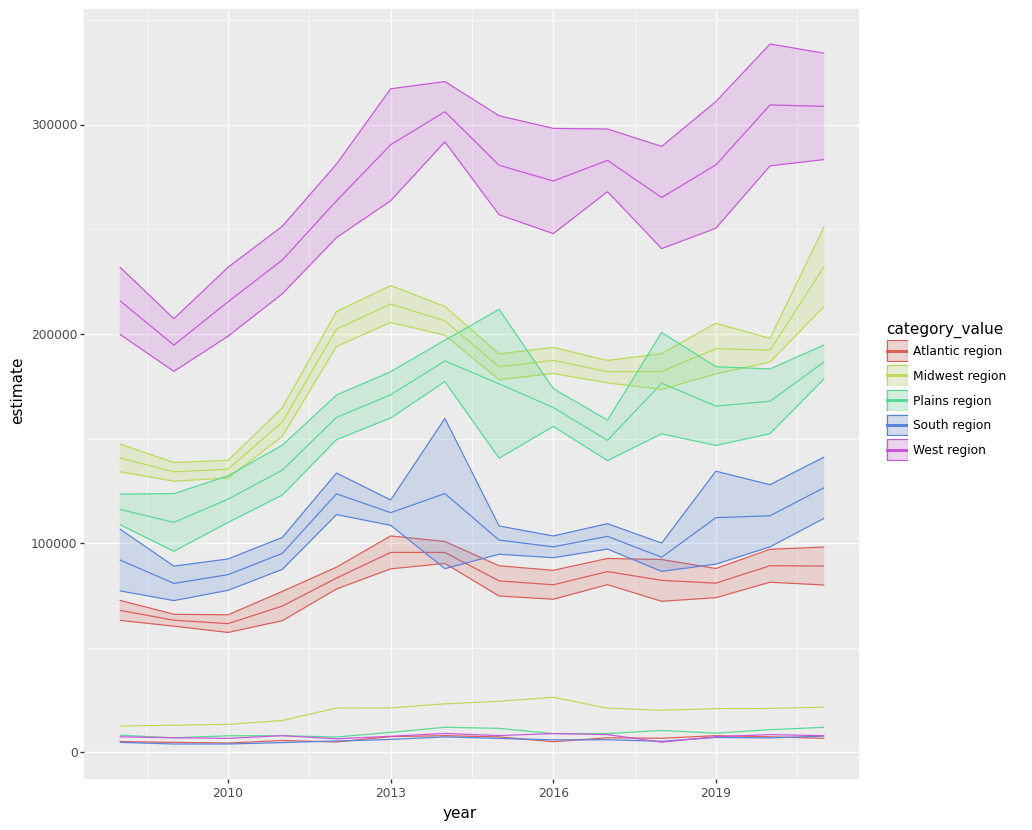

<ggplot: (685146251)>

In [37]:
(
    ggplot(
        dataplot.query("category == 'NASS Region'"),
        aes(x="year", color="category_value", group="group"),
    )
    + geom_line(aes(y="estimate", color="category_value"))
    + geom_line(aes(y="median", color="category_value"))
    + geom_ribbon(aes(ymin="lower", ymax="upper", fill="category_value"), alpha=0.2)
    + theme(figure_size=(10, 10))
)

By production specialty. We only show the livestock categories.

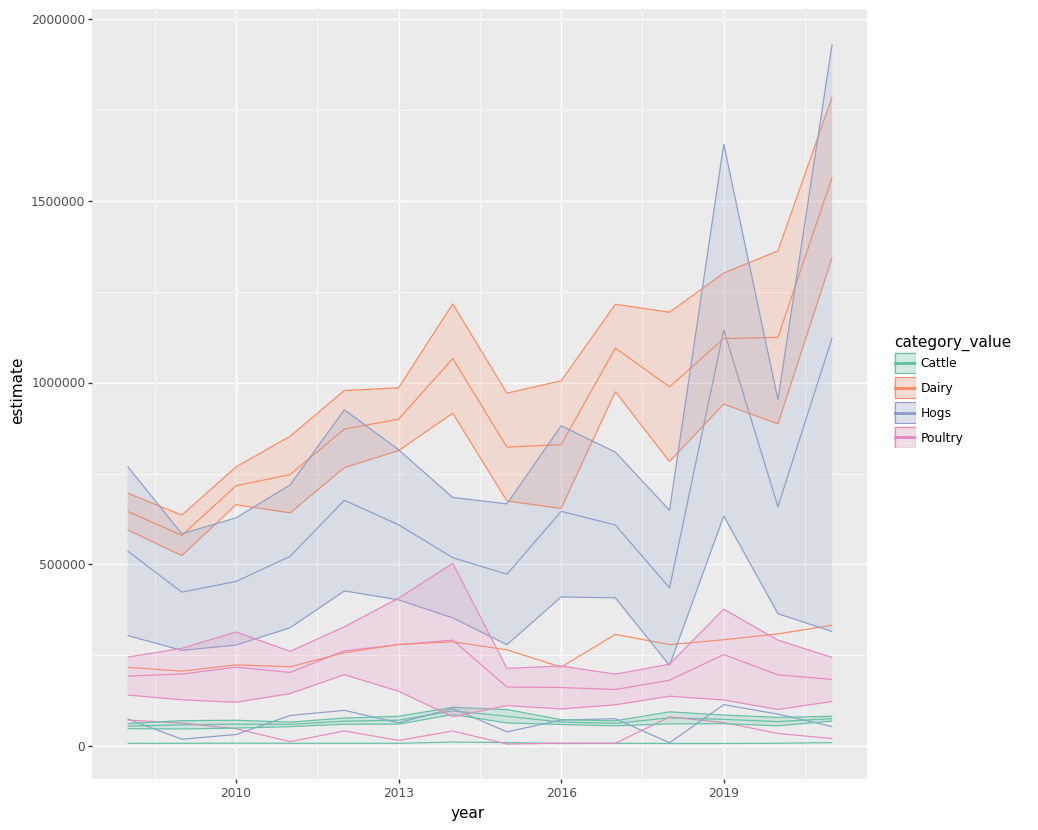

<ggplot: (685147956)>

In [39]:
(
    ggplot(
        dataplot.query(
            "category == 'Production Specialty' and category_value in ['Dairy', 'Cattle', 'Hogs', 'Poultry']"
        ),
        aes(
            x="year",
            color="category_value",
            fill="category_value",
            group="category_value",
        ),
    )
    + geom_line(aes(y="estimate"))
    + geom_line(aes(y="median"))
    + geom_ribbon(aes(ymin="lower", ymax="upper"), alpha=0.2)
    # color theme
    + scale_color_brewer(type="qual", palette="Set2")
    + scale_fill_brewer(type="qual", palette="Set2")
    + theme(figure_size=(10, 10))
)

We can apply a log transformation to the data to make the plot more readable.

/var/folders/0k/_fn4_dgn04b2b44_sfhbshzr0000gp/T/ipykernel_59862/885553557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/0k/_fn4_dgn04b2b44_sfhbshzr0000gp/T/ipykernel_59862/885553557.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/niche/miniforge3/envs/niche/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
/var/folders/0k/_fn4_dgn04b2b44_sfhbshzr0000gp/T/ipykernel_59862/885553557.py:5: SettingWithCopyWarning: 
A value is try

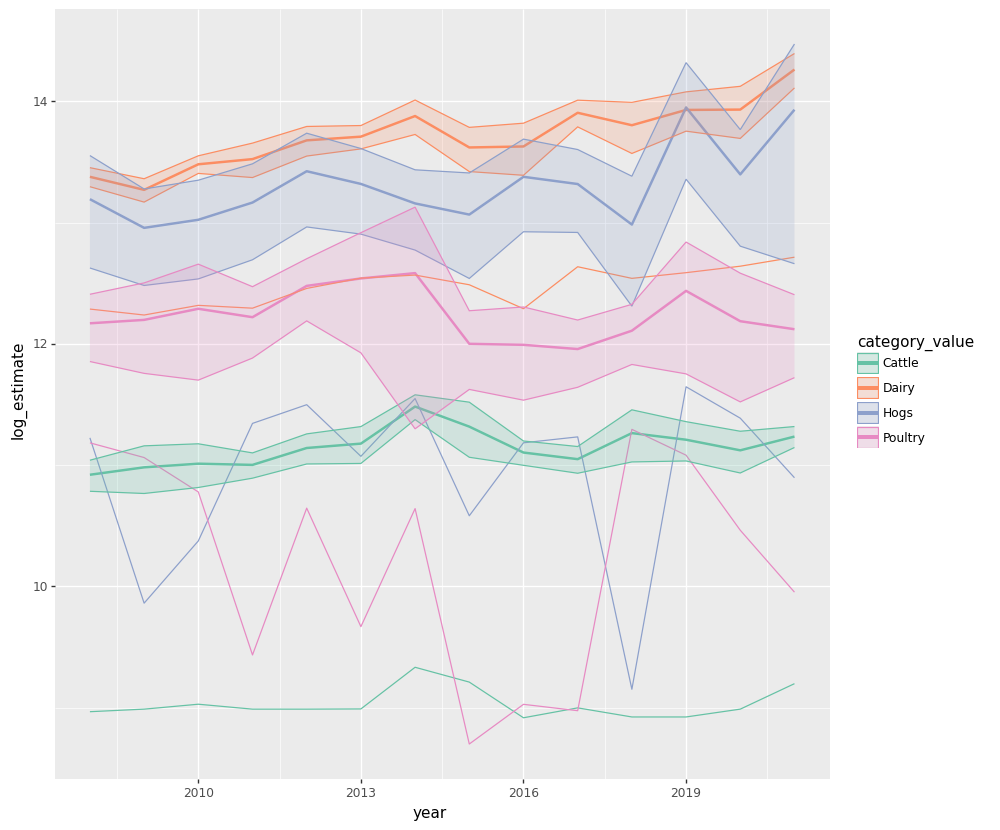

<ggplot: (685725654)>

In [40]:
import numpy as np

dataplot["log_estimate"] = np.log(dataplot["estimate"])
dataplot["log_upper"] = np.log(dataplot["upper"])
dataplot["log_lower"] = np.log(dataplot["lower"])
dataplot["log_median"] = np.log(dataplot["median"])
(
    ggplot(
        dataplot.query(
            "category == 'Production Specialty' and category_value in ['Dairy', 'Cattle', 'Hogs', 'Poultry']"
        ),
        aes(
            x="year",
            color="category_value",
            fill="category_value",
            group="category_value",
        ),
    )
    + geom_line(aes(y="log_estimate"), size=1)
    + geom_line(aes(y="log_median"))
    + geom_ribbon(aes(ymin="log_lower", ymax="log_upper"), alpha=0.2)
    + scale_color_brewer(type="qual", palette="Set2")
    + scale_fill_brewer(type="qual", palette="Set2")
    + theme(figure_size=(10, 10))
)


## 3. SQLite3

After we learn how to interact with an existing database through API, we can also build our own database using our own data. In this section, we will use `sqlite3` to build a database and query the data.


In [41]:
import sqlite3

### Create a database

Creating a database is as simple as creating a file. We can use `sqlite3.connect()` to create a database file.

In [50]:
conn = sqlite3.connect("demo.db") # conn stands for connection

Like we learned in the previous section, a database can contain multiple tables (or surveys, reports). To craete a table, we need to specify the name of the columns and the data type. We also need to specify the primary key, which is a unique identifier for each row. We can create a table named `users` with the following columns:

- `id` - INTEGER (PRIMARY KEY)
- `name` - TEXT
- `gender` - TEXT
- `age` - INTEGER

In [93]:
cur = conn.cursor() # cur stands for cursor
cur.execute(
    """
    CREATE TABLE users (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        gender TEXT,
        age INTEGER
    )
    """
)

Check the table columns

In [94]:
cur.execute("PRAGMA table_info(users)")
cur.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'name', 'TEXT', 1, None, 0),
 (2, 'gender', 'TEXT', 0, None, 0),
 (3, 'age', 'INTEGER', 0, None, 0)]

If you think the command is too complicated, we can use a function to simplify the process.

In [103]:
def list_cols(cur, table):
    cur.execute("PRAGMA table_info(%s)" % table)
    return display([x[1:3] for x in cur.fetchall()])

list_cols(cur, "users")

[('id', 'INTEGER'), ('name', 'TEXT'), ('gender', 'TEXT'), ('age', 'INTEGER')]

### Save the database

We can use `conn.commit()` to save the changes to the database. Like how we deal with a file, we need to close `conn.close()` the database after we are done with it.

In [84]:
conn.commit()
conn.close()

Or we can use a `with` statement to automatically close the database after we are done with it.

In [105]:
with sqlite3.connect("demo.db") as conn:
    cur = conn.cursor()
    list_cols(cur, "users")

[('id', 'INTEGER'), ('name', 'TEXT'), ('gender', 'TEXT'), ('age', 'INTEGER')]

### Insert data

There are two ways to insert data into a table:

Provide information for all columns
- `INSERT INTO users VALUES (1, 'John', 'M', 20)`

Provide information for some columns
- `INSERT INTO users (name, gender) VALUES ('John', 'M')`

In [96]:
cur.execute("INSERT INTO users VALUES (1, 'Mary', 'F', 25)")
cur.execute("INSERT INTO users (name) VALUES ('John')")

Check the data

In [97]:
cur.execute("SELECT * FROM users")
cur.fetchall()

[(1, 'Mary', 'F', 25), (2, 'John', None, None)]

Or wrap it up in a function

In [101]:
def print_table(cur, table):
    cur.execute("SELECT * FROM %s" % table)
    display(cur.fetchall())

print_table(cur, "users")

[(1, 'Mary', 'F', 25),
 (2, 'John', None, None),
 (3, 'Camille', 'female', 40),
 (4, 'Mike', 'male', 25),
 (5, 'Jason', 'male', 35),
 (6, 'Maria', 'female', 20)]

You can actually use `df.to_sql()` to insert data into a table. Parameters we need to consider:

- `if_exists`: If the table already exists, we can choose to `replace` the table, or `append` the data to the existing table.
- `index`: whether to include the index of the dataframe as a column in the table.

In [99]:
df = pd.DataFrame(
    {
        "name": ["Camille", "Mike", "Jason", "Maria"],
        "gender": ["female", "male", "male", "female"],
        "age": [40, 25, 35, 20],
    }
)
df.to_sql("users", conn, if_exists="append", index=False)  # if_exists="replace"

4

In [106]:
print_table(cur, "users")

[(1, 'Mary', 'F', 25),
 (2, 'John', None, None),
 (3, 'Camille', 'female', 40),
 (4, 'Mike', 'male', 25),
 (5, 'Jason', 'male', 35),
 (6, 'Maria', 'female', 20)]

### Add constraints to columns

You might notice that the gender values were not in a consistent format, which should either be [`M`, `F`] or [`Male`, `Female`]. We can use `CHECK` to add constraints to the columns.

Before re-creating the table, we need to drop the table first.

In [107]:
cur.execute("DROP TABLE users")

Then create a new table with the constraints:

* id - INTEGER (PRIMARY KEY)
* name - TEXT - NOT NULL
* gender - TEXT - can only be either 'male' or 'female'
* age - INTEGER - must be in the range of 0 to 150
* weight - REAL - must be in the range of 0 to 300

In [108]:
cur.execute(
    """
    CREATE TABLE users (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        gender TEXT CHECK(gender IN ("male", "female")),
        age INTEGER CHECK(age >= 0 AND age <= 150),
        weight REAL CHECK(weight >= 0 AND weight <= 300)
    )
    """
)

Now, let's try to insert data again. We can start with expected values:

In [110]:
cur.execute("INSERT INTO users VALUES (1, 'Mary', 'female', 25, 150)")

In [111]:
print_table(cur, "users")

[(1, 'Mary', 'female', 25, 150.0)]

Let's try different exceptions:

In [112]:
cur.execute("INSERT INTO users VALUES (2, 'Mary', 'f', 25, 150)")

IntegrityError: CHECK constraint failed: gender IN ("male", "female")

In [114]:
cur.execute("INSERT INTO users VALUES (2, 'Mary', 'female', -3, 200)")

IntegrityError: CHECK constraint failed: age >= 0 AND age <= 150

By setting constraints to the columns, it is easier to ensure the data quality when the database is growing. Here is a complete code for creating a `user` table with data inserted.

In [120]:
with sqlite3.connect("demo.db") as conn:
    cur = conn.cursor()
    cur.execute(
    """
    CREATE TABLE users (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        gender TEXT CHECK(gender IN ("male", "female")),
        age INTEGER CHECK(age >= 0 AND age <= 150),
        weight REAL CHECK(weight >= 0 AND weight <= 300)
    )
    """)

    df = pd.DataFrame(
        {
            "name": ["Camille", "Mike", "Jason", "Maria"],
            "gender": ["female", "male", "male", "female"],
            "age": [40, 25, 35, 20],
            "weight": [150, 200, 180, 120],
        }
    )
    df.to_sql("users", conn, if_exists="append", index=False)
    print_table(cur, "users")

### Reference integrity

We already have a table `users` to define users' information. Now, let's create another table `walks` to record the walking activity.

In [ ]:
conn = sqlite3.connect("demo.db")
cur = conn.cursor()
cur.execute(
    """
    CREATE TABLE walks (
        id INTEGER PRIMARY KEY,
        user_id INTEGER NOT NULL,
        date TEXT NOT NULL,
        distance FLOAT NOT NULL,
        duration INTEGER NOT NULL,
        FOREIGN KEY (user_id) REFERENCES users (id))
    """
)

You may notice that we set `user_id` as the foreign key. This means that the value of `user_id` must correspond to the value of `id` in the `users` table when we need to consider the relationship between the two tables. This is called a `reference integrity`. We can use `REFERENCES` to set the reference integrity.

The `walks` table include the information of the walking date, distance, and duration.Let's insert data into this `walks` table.

In [133]:
data = pd.DataFrame(
    data={
        "user_id": [1, 1, 1, 2, 2, 3, 3, 4, 4, 4],
        "date": [
            "02-26-2023",
            "02-27-2023",
            "02-28-2023",
            "02-26-2023",
            "02-27-2023",
            "02-26-2023",
            "02-27-2023",
            "02-26-2023",
            "02-27-2023",
            "02-28-2023",
        ],
        "distance": [1.2, 1.5, 1.7, 2.2, 2.5, 3.2, 3.5, 4.2, 4.5, 4.7],
        "duration": [30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
    }
)
data.to_sql("walks", conn, if_exists="append", index=False)

10

In [134]:
print_table(cur, "walks")

[(1, '02-26-2023', 1.2, 30),
 (1, '02-27-2023', 1.5, 40),
 (1, '02-28-2023', 1.7, 50),
 (2, '02-26-2023', 2.2, 60),
 (2, '02-27-2023', 2.5, 70),
 (3, '02-26-2023', 3.2, 80),
 (3, '02-27-2023', 3.5, 90),
 (4, '02-26-2023', 4.2, 100),
 (4, '02-27-2023', 4.5, 110),
 (4, '02-28-2023', 4.7, 120)]

Ok, now we have two tables with data inserted. We can use `JOIN` to put the data from two tables together.

In [135]:
cur.execute(
    """
    SELECT * FROM walks JOIN users
    ON walks.user_id = users.id
    """
)
cur.fetchall()

[(1, '02-26-2023', 1.2, 30, 1, 'Camille', 'female', 40, 150.0),
 (1, '02-27-2023', 1.5, 40, 1, 'Camille', 'female', 40, 150.0),
 (1, '02-28-2023', 1.7, 50, 1, 'Camille', 'female', 40, 150.0),
 (2, '02-26-2023', 2.2, 60, 2, 'Mike', 'male', 25, 200.0),
 (2, '02-27-2023', 2.5, 70, 2, 'Mike', 'male', 25, 200.0),
 (3, '02-26-2023', 3.2, 80, 3, 'Jason', 'male', 35, 180.0),
 (3, '02-27-2023', 3.5, 90, 3, 'Jason', 'male', 35, 180.0),
 (4, '02-26-2023', 4.2, 100, 4, 'Maria', 'female', 20, 120.0),
 (4, '02-27-2023', 4.5, 110, 4, 'Maria', 'female', 20, 120.0),
 (4, '02-28-2023', 4.7, 120, 4, 'Maria', 'female', 20, 120.0)]

You see that the user information was added to the `walks` table. This is similar to how we use `df.merge()` to combine two dataframes in Pandas.

In [136]:
df_users = pd.read_sql("SELECT * FROM users", conn)
df_walks = pd.read_sql("SELECT * FROM walks", conn)
pd.merge(df_walks, df_users, left_on="user_id", right_on="id")

,user_id,date,distance,duration,id,name,gender,age,weight
0,1,02-26-2023,1.2,30,1,Camille,female,40,150.0
1,1,02-27-2023,1.5,40,1,Camille,female,40,150.0
2,1,02-28-2023,1.7,50,1,Camille,female,40,150.0
3,2,02-26-2023,2.2,60,2,Mike,male,25,200.0
4,2,02-27-2023,2.5,70,2,Mike,male,25,200.0
5,3,02-26-2023,3.2,80,3,Jason,male,35,180.0
6,3,02-27-2023,3.5,90,3,Jason,male,35,180.0
7,4,02-26-2023,4.2,100,4,Maria,female,20,120.0
8,4,02-27-2023,4.5,110,4,Maria,female,20,120.0
9,4,02-28-2023,4.7,120,4,Maria,female,20,120.0


### SQlite3 VS. Pandas

Here we will put the major functionalities of SQLite3 and Pandas side by side to see how they compare.

#### Sorting

SQLite3

In [138]:
cur.execute("SELECT * FROM users ORDER BY age DESC")  # or ASC
cur.fetchall()

[(1, 'Camille', 'female', 40, 150.0),
 (3, 'Jason', 'male', 35, 180.0),
 (2, 'Mike', 'male', 25, 200.0),
 (4, 'Maria', 'female', 20, 120.0)]

Pandas

In [139]:
df_users.sort_values(by="age", ascending=False)

,id,name,gender,age,weight
0,1,Camille,female,40,150.0
2,3,Jason,male,35,180.0
1,2,Mike,male,25,200.0
3,4,Maria,female,20,120.0


#### Filtering

SQLite3

In [141]:
cur.execute("SELECT age, gender FROM users WHERE age > 30")
cur.fetchall()

[(40, 'female'), (35, 'male')]

Pandas

In [140]:
df_users.loc[:, ["age", "gender"]].query("age > 30")

,age,gender
0,40,female
2,35,male


SQLite3

In [143]:
cur.execute(
    """
    SELECT name, weight FROM users
    WHERE name LIKE '%m%'
    OR name LIKE '%n%'
    """
)
cur.fetchall()

[('Camille', 150.0), ('Mike', 200.0), ('Jason', 180.0), ('Maria', 120.0)]

Pandas

In [142]:
df_users.loc[:, ["name", "weight"]].query(
    """
    name.str.upper().str.contains('M') |\
    name.str.upper().str.contains('N')
    """
)

,name,weight
0,Camille,150.0
1,Mike,200.0
2,Jason,180.0
3,Maria,120.0


#### Grouping

SQLite3

In [144]:
cur.execute(
    """
    SELECT user_id, avg(distance), sum(duration), count(distance)
    FROM walks GROUP BY user_id
    """
)
cur.fetchall()

[(1, 1.4666666666666668, 120, 3),
 (2, 2.35, 130, 2),
 (3, 3.35, 170, 2),
 (4, 4.466666666666666, 330, 3)]

Pandas

In [147]:
df_walks.groupby("user_id").aggregate(
    distance_mean=("distance", "mean"),
    duration_sum=("duration", "sum"),
    distance_count=("distance", "count"),
)

,distance_mean,duration_sum,distance_count
user_id,,,
1,1.466667,120,3
2,2.350000,130,2
3,3.350000,170,2
4,4.466667,330,3


### sqlite_master

`sqliet_master` is a system table that contains the information of all tables in the database. We can use `SELECT * FROM sqlite_master` to get the information of all tables. The output will look like this:

* `type`: the type of the object. In this case, it is `table`.
* `name`: the name of the table.
* `tbl_name`: the name of the table.
* `rootpage`: the page number of the root b-tree page for the table.
* `sql`: the SQL statement used to create the table.

In [149]:
cur.execute("SELECT * FROM sqlite_master")
cur.fetchall()

[('table',
  'users',
  'users',
  2,
  'CREATE TABLE users (\n        id INTEGER PRIMARY KEY,\n        name TEXT NOT NULL,\n        gender TEXT CHECK(gender IN ("male", "female")),\n        age INTEGER CHECK(age >= 0 AND age <= 150),\n        weight REAL CHECK(weight >= 0 AND weight <= 300)\n    )'),
 ('table',
  'walks',
  'walks',
  3,
  'CREATE TABLE "walks" (\n"user_id" INTEGER,\n  "date" TEXT,\n  "distance" REAL,\n  "duration" INTEGER\n)')]

Or simply list all the tables in the database.

In [150]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('users',), ('walks',)]

### Collection of functions

In [102]:
def list_cols(cur, table):
    cur.execute("PRAGMA table_info(%s)" % table)
    cols = [x[1:3] for x in cur.fetchall()]
    return display(cols)

def print_table(cur, table):
    cur.execute("SELECT * FROM %s" % table)
    output = cur.fetchall()
    display(output)

def clean_table(cur, table):
    cur.execute("DELETE FROM %s" % table)

def drop_table(cur, table):
    cur.execute("DROP TABLE %s" % table)